# Homework 4: Image Classification on CIFAR-10
  🛫 🚘 🐦 🐱 🦌 🐶 🐸 🐴 🚢 🛻

## Information before starting

In this problem, we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. Make sure that you are familiar with torch `Tensor`s, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`), ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`). **Make sure to read through all instructions in both this notebook and in the PDF while completing this problem!**

### Copying this Colab Notebook to your Google Drive



Since the course staff is the author of this notebook, you cannot make any lasting changes to it. You should make a copy of it to your Google Drive by clicking **File -> Save a Copy in Drive**.

### Problem Introduction

You've already had some practice using the PyTorch library in HW3, but this problem dives into training more complex deep learning models.

The specific task we are trying to solve in this problem is image classification. We're using a common dataset called CIFAR-10 which has 60,000 images separated into 10 classes:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

We've provided an end-to-end example of loading data, training a model, and performing evaluation. We recommend using this code as a template for your implementations of the more complex models. Feel free to modify or reuse any of the functions we provide.

**Unlike other coding problems in the past, this one does not include an autograded component.**

### Enabling GPU

We are using Google Colab because it has free GPU runtimes available. GPUs can accelerate training times for this problem by 10-100x when compared to using CPU. To use the GPU runtime on Colab, make sure to **enable** the runtime by going to **Runtime -> Change runtime type -> Select T4 GPU under "Hardware accelerator"**.

Note that GPU runtimes are *limited* on Colab. We recommend limiting your training to short-running jobs (under 15 minutes each) and spread your work over time, if possible. Colab *will* limit your usage of GPU time, so plan ahead and be prepared to take breaks during training. If you have used up your quota for GPU, check back in a day or so to be able to enable GPU again.

Your code will still run on CPU, so if you are just starting to implement your code or have been GPU limited by Colab, you can still make changes and run your code - it will just be quite a bit slower. You can also choose to download your notebook and run locally if you have a personal GPU or have a faster CPU than the one Colab provides. If you choose to do this, you may need to install the packages that this notebook depends on to your `cse446` conda environment or to another Python environment of your choice.

To check if you have enabled GPU, run the following cell. If `device` is `cuda`, it means that GPU has been enabled successfully.

In [ ]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

### Submitting your assignment

Once you are done with the problem, make sure to put all of your necessary figures into your PDF submission. Then, download this notebook as a Python file (`.py`) by going to **File -> Download -> Download `.py`**. Rename this file as `hw4-a3.py` and upload to the Gradescope submission for HW4 code.

## End-to-end Example

### Background and Setup

1. We first import all of the dependencies required for this problem:

In [ ]:
import torch
from torch import nn
import numpy as np

from typing import Tuple, Union, List, Callable
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

2. And check if we are using GPU, if it is available. (Make sure to set your runtime to enable GPU!)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

cuda


*To use the GPU, you will need to send both the model and the data to a device; this transfers the model from its default location on CPU to the GPU.*

*Note that torch operations on Tensors will fail if they are not located on the same device. Here's a small example of how to send the model and data to your device:*

  ```python
  model = model.to(DEVICE)  # Sending a model to GPU

  for x, y in tqdm(data_loader):
    x, y = x.to(DEVICE), y.to(DEVICE)
  ```
*When reading tensors you may need to send them back to cpu, you can do so with `x = x.cpu()`*

3. Now, let's load the CIFAR-10 data. We can take advantage of public datasets available through PyTorch torchvision!

In [ ]:
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


4. Finally, like we did in HW3, we'll use the PyTorch `DataLoader` to wrap our datasets. You've already seen that `DataLoader`s handle batching, shuffling, and iterating over data, and this is really useful for this problem as well!

*Since training on all of the 50,000 training samples can be prohibitively expensive, we define a flag called* `SAMPLE_DATA` *that controls if we should make the dataset smaller for faster training time. When* `SAMPLE_DATA=true`, *we'll only use 10% of our training data when training and performing our hyperparameter searches.*  **Make sure that you've set `SAMPLE_DATA=false` when you want to perform your final training loops for submission!**

In [ ]:
SAMPLE_DATA = False # set this to True if you want to speed up training when searching for hyperparameters!

In [ ]:
batch_size = 128

if SAMPLE_DATA:
  train_dataset, _ = random_split(train_dataset, [int(0.1 * len(train_dataset)), int(0.9 * len(train_dataset))]) # get 10% of train dataset and "throw away" the other 90%

train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

Now, we're ready to train!

### Logistic Regression Example

Let's first take a look at our data to get an understanding of what we are doing. As a reminder, CIFAR-10 is a dataset containing images split into 10 classes.

A single batch of images has shape: torch.Size([128, 3, 32, 32])
A single RGB image has 3 channels, width 32, and height 32.
Size of a batch of images flattened with view: torch.Size([128, 3072])
Size of a batch of images flattened with flatten: torch.Size([128, 3072])
True
This image is labeled as class frog


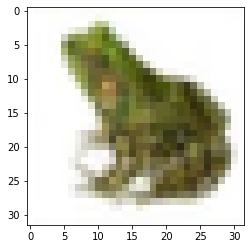

In [ ]:
imgs, labels = next(iter(train_loader))
print(f"A single batch of images has shape: {imgs.size()}")
example_image, example_label = imgs[0], labels[0]
c, w, h = example_image.size()
print(f"A single RGB image has {c} channels, width {w}, and height {h}.")

# This is one way to flatten our images
batch_flat_view = imgs.view(-1, c * w * h)
print(f"Size of a batch of images flattened with view: {batch_flat_view.size()}")

# This is another equivalent way
batch_flat_flatten = imgs.flatten(1)
print(f"Size of a batch of images flattened with flatten: {batch_flat_flatten.size()}")

# The new dimension is just the product of the ones we flattened
d = example_image.flatten().size()[0]
print(c * w * h == d)

# View the image
t =  torchvision.transforms.ToPILImage()
plt.imshow(t(example_image))

# These are what the class labels in CIFAR-10 represent. For more information,
# visit https://www.cs.toronto.edu/~kriz/cifar.html
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
           "horse", "ship", "truck"]
print(f"This image is labeled as class {classes[example_label]}")


In this problem, we will attempt to predict what class an image is labeled as.

1. First, let's create our model. Note: for a linear model we could flatten the data before passing it into the model, but that is not the case for convolutional neural networks.

In [ ]:
def linear_model() -> nn.Module:
    """Instantiate a linear model and send it to device."""
    model =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, 10)
         )
    return model.to(DEVICE)

2. Let's define a method to train this model using SGD as our optimizer.

In [ ]:
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
    )-> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Trains a model for the specified number of epochs using the loaders.

    Returns:
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
    """

    loss = DynamicBPNet()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        # Main training loop; iterate over train_loader. The loop
        # terminates when the train loader finishes iterating, which is one epoch.
        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss = train_loss + batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc = train_acc + batch_acc.item()

            batch_loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        # Validation loop; use .no_grad() context manager to save memory.
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss = val_loss + v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc = val_acc + batch_acc.item()
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))

    return train_losses, train_accuracies, val_losses, val_accuracies


3. Now, let's define our hyperparameter search. For this problem, we will be using SGD. The two hyperparameters for our linear model trained with SGD are the learning rate and momentum. Only learning rate will be searched for in this example, but you will be tuning multiple hyperparameters. **Feel free to experiment with hyperparameters and how you search. We recommend implementing random search!**

*Note: We ask you to plot the accuracies for the 3 best models for each structure, so you will need to return multiple sets of hyperparameters for the homework.*

In [ ]:
def parameter_search(train_loader: DataLoader,
                     val_loader: DataLoader,
                     model_fn:Callable[[], nn.Module]) -> float:
    """
    Parameter search for our linear model using SGD.

    Args:
    train_loader: the train dataloader.
    val_loader: the validation dataloader.
    model_fn: a function that, when called, returns a torch.nn.Module.

    Returns:
    The learning rate with the least validation loss.
    NOTE: you may need to modify this function to search over and return
     other parameters beyond learning rate.
    """
    num_iter = 10
    best_loss = torch.tensor(np.inf)
    best_lr = 0.0

    lrs = torch.linspace(10 ** (-6), 10 ** (-1), num_iter)

    for lr in lrs:
        print(f"trying learning rate {lr}")
        model = model_fn()
        optim = SGD(model.parameters(), lr)
        train_loss, train_acc, val_loss, val_acc = train(
            model,
            optim,
            train_loader,
            val_loader,
            epochs=20
            )

        if min(val_loss) < best_loss:
            best_loss = min(val_loss)
            best_lr = lr

    return best_lr

4. Now that we have everything, we can train and evaluate our model.

In [ ]:
best_lr = parameter_search(train_loader, val_loader, linear_model)

trying learning rate 9.999999974752427e-07


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.011112000793218613


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.02222300134599209


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.033334001898765564


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.04444500058889389


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.05555599927902222


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.06666699796915054


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.07777799665927887


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.08888900279998779


  0%|          | 0/20 [00:00<?, ?it/s]

trying learning rate 0.10000000149011612


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
model = linear_model()
optimizer = SGD(model.parameters(), best_lr)

In [ ]:
# We are using 20 epochs for this example. You may have to use more.
train_loss, train_accuracy, val_loss, val_accuracy = train(
    model, optimizer, train_loader, val_loader, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

5. We can also plot the training and validation accuracy for each epoch.

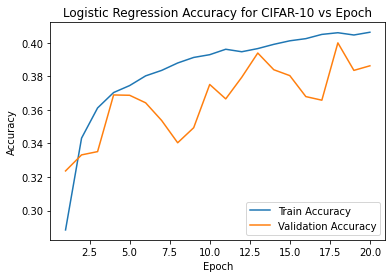

In [ ]:
epochs = range(1, 21)
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Logistic Regression Accuracy for CIFAR-10 vs Epoch")
plt.show()

The last thing we have to do is evaluate our model on the testing data.

In [ ]:
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
    """Computes test loss and accuracy of model on loader."""
    loss = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for (batch, labels) in loader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            y_batch_pred = model(batch)
            batch_loss = loss(y_batch_pred, labels)
            test_loss = test_loss + batch_loss.item()

            pred_max = torch.argmax(y_batch_pred, 1)
            batch_acc = torch.sum(pred_max == labels)
            test_acc = test_acc + batch_acc.item()
        test_loss = test_loss / len(loader)
        test_acc = test_acc / (batch_size * len(loader))
        return test_loss, test_acc

In [ ]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.38558148734177217


The rest is yours to code. You can structure the code any way you would like.

We do advise making using code cells and functions (train, search, predict etc.) for each subproblem, since they will make your code easier to debug.

Also note that several of the functions above can be reused for the various different models you will implement for this problem; i.e., you won't need to write a new `evaluate()`.

## Your Turn!

The rest is yours to code. You are welcome to structure the code any way you would like.

We do advise making using code cells and functions (train, search, predict etc.) for each subproblem, since they will make your code easier to debug.

Also note that several of the functions above can be reused for the various different models you will implement for this problem; i.e., you won't need to write a new `evaluate()`. Before you reuse functions though, make sure they are compatible with what the assignment is asking for.

### Submitting Code

And as a last reminder, once you are done with the problem, make sure to put all of your necessary figures into your PDF submission. Then, download this notebook as a Python file (`.py`) by going to **File -> Download -> Download `.py`**. Rename this file as `hw4-a3.py` and upload to the Gradescope submission for HW4 code.

In [ ]:
# Your code goes here...